In [15]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from analysis import collection, analysis, emg
from analysis import plot as analysis_plot
import scipy as sp
import pandas as pd
from sklearn.mixture import BayesianGaussianMixture
from sklearn.base import clone
import seaborn as sns
import pickle
from scipy.stats import multivariate_normal

    initialize gmm model

    for each trial:

    fit a GMM to the trial with N modes

    store this model

    update initalization to the current fit for the next trial

    plot model means over trials?

projection into 2d:

$$ x \propto N(\mu, \Sigma) $$
$$ y = Ax + b $$
$$ y \propto N(A\mu + b, A\Sigma A^T) $$

In [2]:
subject_emg_stacks = np.load("subject_emg_stacks.npy")
print(subject_emg_stacks.shape)

(46, 45, 12, 1072, 64)


In [3]:
# collection_name = "emg_olympics"
# task_name = "center_hold"
# c = collection.Collection(collection_name)
# subjects = c.alphabetically_sorted_subjects()

In [9]:
# with open('olympics_subjects.pkl', 'wb') as handle:
#     pickle.dump(subjects, handle)

In [4]:
with open('olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)
len(subjects)

46

In [5]:
reward_df = pd.read_pickle("trajectory_dataframe.pkl")
mean_rewards = reward_df.groupby(level=["subject"]).mean()["reward"]**-1
mean_rewards.shape

(46,)

In [6]:
subject_hits = []
for subject in subjects:
    hits = 0
    for s in subject.tasks[task_name].sorted_sessions():
        for t in s.sorted_trials():
            if t.outcome == "Hit":
                hits += 1
    subject_hits.append(hits)
hit_fractions = [sh/540 for sh in subject_hits]

In [7]:
plt.plot(hit_fractions, mean_rewards,'ko')
plt.xlabel("hit fraction")
plt.ylabel("mean rewards")

Text(0, 0.5, 'mean rewards')

In [5]:
subject_idx = 29
subject = subjects[subject_idx]
decoder = subject.decoder[-2:]

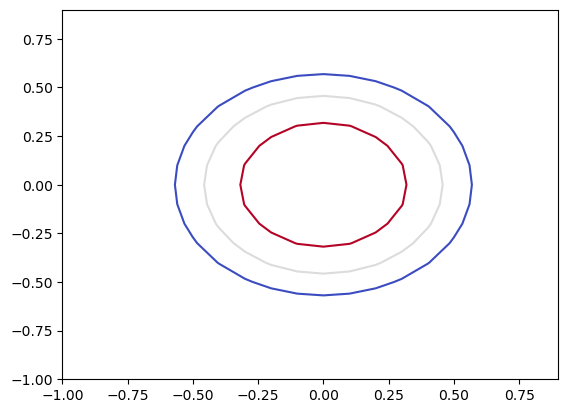

In [5]:
def transform_mean(decoder, mean):
    return decoder @ mean

def transform_covariance(decoder, covariance):
    return decoder @ covariance @ decoder.T

def plot_gaussian(mean, covariance, ax=None, xlims=None,ylims=None):
    if xlims is None:
        xlims = [-1,1]
    if ylims is None:
        ylims = [-1,1]
    x, y = np.mgrid[xlims[0]:xlims[1]:.1, ylims[0]:ylims[1]:.1]
    rv = multivariate_normal(mean, covariance)
    data = np.dstack((x, y))
    z = rv.pdf(data)
    zmax = z.max()
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.contour(x, y, z,[zmax*0.85,zmax*0.9,zmax*0.95],cmap='coolwarm')

def plot_eigs(mean,covariance,ax=None,color="k",**kwargs):
    assert covariance.shape == (2,2)
    evals, evecs = np.linalg.eig(covariance)
    if ax is None:
        _, ax = plt.subplots(1,1)
    ax.arrow(mean[0],mean[1],evals[0]*evecs[0,0],evals[0]*evecs[1,0],head_width=0.0,color=color,**kwargs)
    ax.arrow(mean[0],mean[1],evals[1]*evecs[0,1],evals[1]*evecs[1,1],head_width=0.0,color=color,**kwargs)
    ax.arrow(mean[0],mean[1],-evals[0]*evecs[0,0],-evals[0]*evecs[1,0],head_width=0.0,color=color,**kwargs)
    ax.arrow(mean[0],mean[1],-evals[1]*evecs[0,1],-evals[1]*evecs[1,1],head_width=0.0,color=color,**kwargs)

# test
# c = np.array([[2,0],[0,1]])
# m = np.zeros(2)
# plot_eigs(m,c)

fig, ax = plt.subplots(1,1)
plot_gaussian(np.zeros(2),np.eye(2),xlims=[-1,1],ylims=[-1,1],ax=ax)

In [12]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(center, cov, ax, n_std=3.0, edgecolor="k", facecolor='none', **kwargs):
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        edgecolor=edgecolor,
        **kwargs)
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(center[0], center[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

[array([17,  9]), array([ 7, 22]), array([15, 13]), array([ 1, 17]), array([ 4, 14]), array([14,  1]), array([22, 19]), array([13, 18]), array([10,  3]), array([2, 0]), array([18, 24]), array([23, 16]), array([24,  2]), array([19, 11]), array([ 8, 15]), array([16, 20]), array([21, 23]), array([3, 8]), array([12,  5]), array([0, 4]), array([ 9, 21]), array([6, 7]), array([11, 12]), array([20, 10]), array([5, 6])]


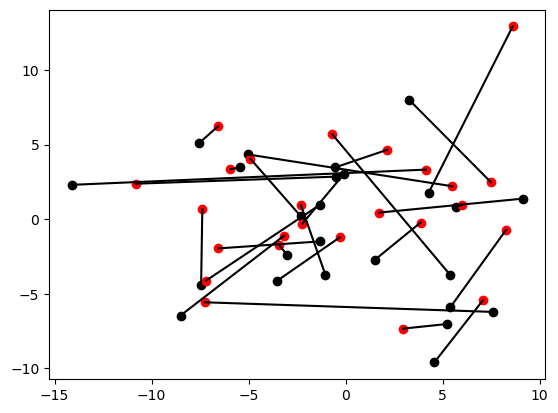

In [6]:
def closest_pairs(points1, points2):
    # assert points1.shape[0] > points1.shape[1]
    # assert points2.shape[0] > points2.shape[1]
    # distances between 1 and 2
    distance_matrix = sp.spatial.distance.cdist(points1, points2)
    # indexes for rows and columns
    i1, i2 = np.indices((points1.shape[0],points2.shape[0]))
    # pair the indexes [row,col],[row,col], ...
    index_pairs = np.column_stack([i1.reshape(-1),i2.reshape(-1)])
    # flatten distance matrix the same way as indexes
    distances = distance_matrix.reshape(-1)
    # sort distances
    sorted_distance_indices = np.argsort(distances)
    stored_pairs = []
    used_pairs_1 = []
    used_pairs_2 = []
    # for every pairwise distance, shortest to longest
    for _, pair_idx in enumerate(sorted_distance_indices):
        # grab the original index pair to know which points
        pair = index_pairs[pair_idx]
        # check if we've seen either of these points before
        if (not pair[0] in used_pairs_1) and (not pair[1] in used_pairs_2):
            # if we haven't, store them
            stored_pairs.append(pair)
            used_pairs_1.append(pair[0])
            used_pairs_2.append(pair[1])
    return stored_pairs


# visual test
df1 = np.random.uniform(-1,1,(25,64))
df2 = np.random.uniform(-1,1,(25,64))
pairs = closest_pairs(df1,df2)
print(pairs)
test_decoder = np.random.normal(size=(2,64))
tdf1 = (test_decoder @ df1.T).T
tdf2 = (test_decoder @ df2.T).T
for p1, p2 in zip(tdf1, tdf2):
    plt.plot(p1[0],p1[1],"ro")
    plt.plot(p2[0],p2[1],"ko")
for pair in pairs:
    plt.plot([tdf1[pair[0]][0],tdf2[pair[1]][0]],[tdf1[pair[0]][1],tdf2[pair[1]][1]],"k-")

In [7]:
subject_calibration_stacks = np.load("subject_calibration_stacks.npy")
print(subject_calibration_stacks.shape)

subject_movement_stacks = np.load("subject_movement_stacks.npy")
print(subject_movement_stacks.shape)

(46, 2, 32, 64, 1000)
(46, 2, 14, 64, 1800)


## fit calibration models

In [18]:
subject_calibration_models = []
for subject_idx in range(len(subjects)):
    model = BayesianGaussianMixture(n_components=4,
                                    weight_concentration_prior_type='dirichlet_process',
                                    weight_concentration_prior=1.e-8,
                                    init_params="k-means++",
                                    max_iter=200,
                                    n_init=3,
                                    warm_start=True,
                                    # verbose=True,
                                    random_state=0,
                                    # degrees_of_freedom_prior=64
                                    )
    data1 = subject_calibration_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
    # data2 = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
    # data = np.concatenate([data1,data2],axis=0)
    data = analysis.remove_nan_rows(data1)
    print(f"Fitting subject: {subject_idx}")
    model.fit(data)
    subject_calibration_models.append(model)
    model = clone(model)

Fitting subject: 0
Fitting subject: 1
Fitting subject: 2
Fitting subject: 3
Fitting subject: 4
Fitting subject: 5
Fitting subject: 6
Fitting subject: 7
Fitting subject: 8
Fitting subject: 9
Fitting subject: 10
Fitting subject: 11
Fitting subject: 12
Fitting subject: 13
Fitting subject: 14
Fitting subject: 15
Fitting subject: 16
Fitting subject: 17
Fitting subject: 18
Fitting subject: 19
Fitting subject: 20
Fitting subject: 21
Fitting subject: 22
Fitting subject: 23
Fitting subject: 24
Fitting subject: 25
Fitting subject: 26
Fitting subject: 27
Fitting subject: 28
Fitting subject: 29
Fitting subject: 30
Fitting subject: 31
Fitting subject: 32
Fitting subject: 33
Fitting subject: 34
Fitting subject: 35
Fitting subject: 36
Fitting subject: 37
Fitting subject: 38
Fitting subject: 39
Fitting subject: 40
Fitting subject: 41
Fitting subject: 42
Fitting subject: 43
Fitting subject: 44
Fitting subject: 45


### save calibration models

In [19]:
with open('subject_calibration_models.pkl', 'wb') as handle:
    pickle.dump(subject_calibration_models, handle)

In [20]:
with open('subject_calibration_models.pkl', 'rb') as handle:
    subject_calibration_models = pickle.load(handle)
print(len(subject_calibration_models))

46


## fit movement models

In [ ]:
subject_movement_models = []
for subject_idx in range(len(subjects)):
    model = BayesianGaussianMixture(n_components=4,
                                    weight_concentration_prior_type='dirichlet_process',
                                    weight_concentration_prior=1.e-8,
                                    init_params="k-means++",
                                    max_iter=200,
                                    n_init=3,
                                    warm_start=True,
                                    # verbose=True,
                                    random_state=0,
                                    # degrees_of_freedom_prior=64
                                    )
    data2 = subject_movement_stacks[subject_idx].transpose((0,1,3,2)).reshape(-1,64)
    data = analysis.remove_nan_rows(data2)
    print(f"Fitting subject: {subject_idx}")
    model.fit(data)
    subject_movement_models.append(model)
    model = clone(model)

In [ ]:
with open('subject_movement_models.pkl', 'wb') as handle:
    pickle.dump(subject_movement_models, handle)

In [ ]:
with open('subject_movement_models.pkl', 'rb') as handle:
    subject_movement_models = pickle.load(handle)
print(len(subject_movement_models))

## look at prior models

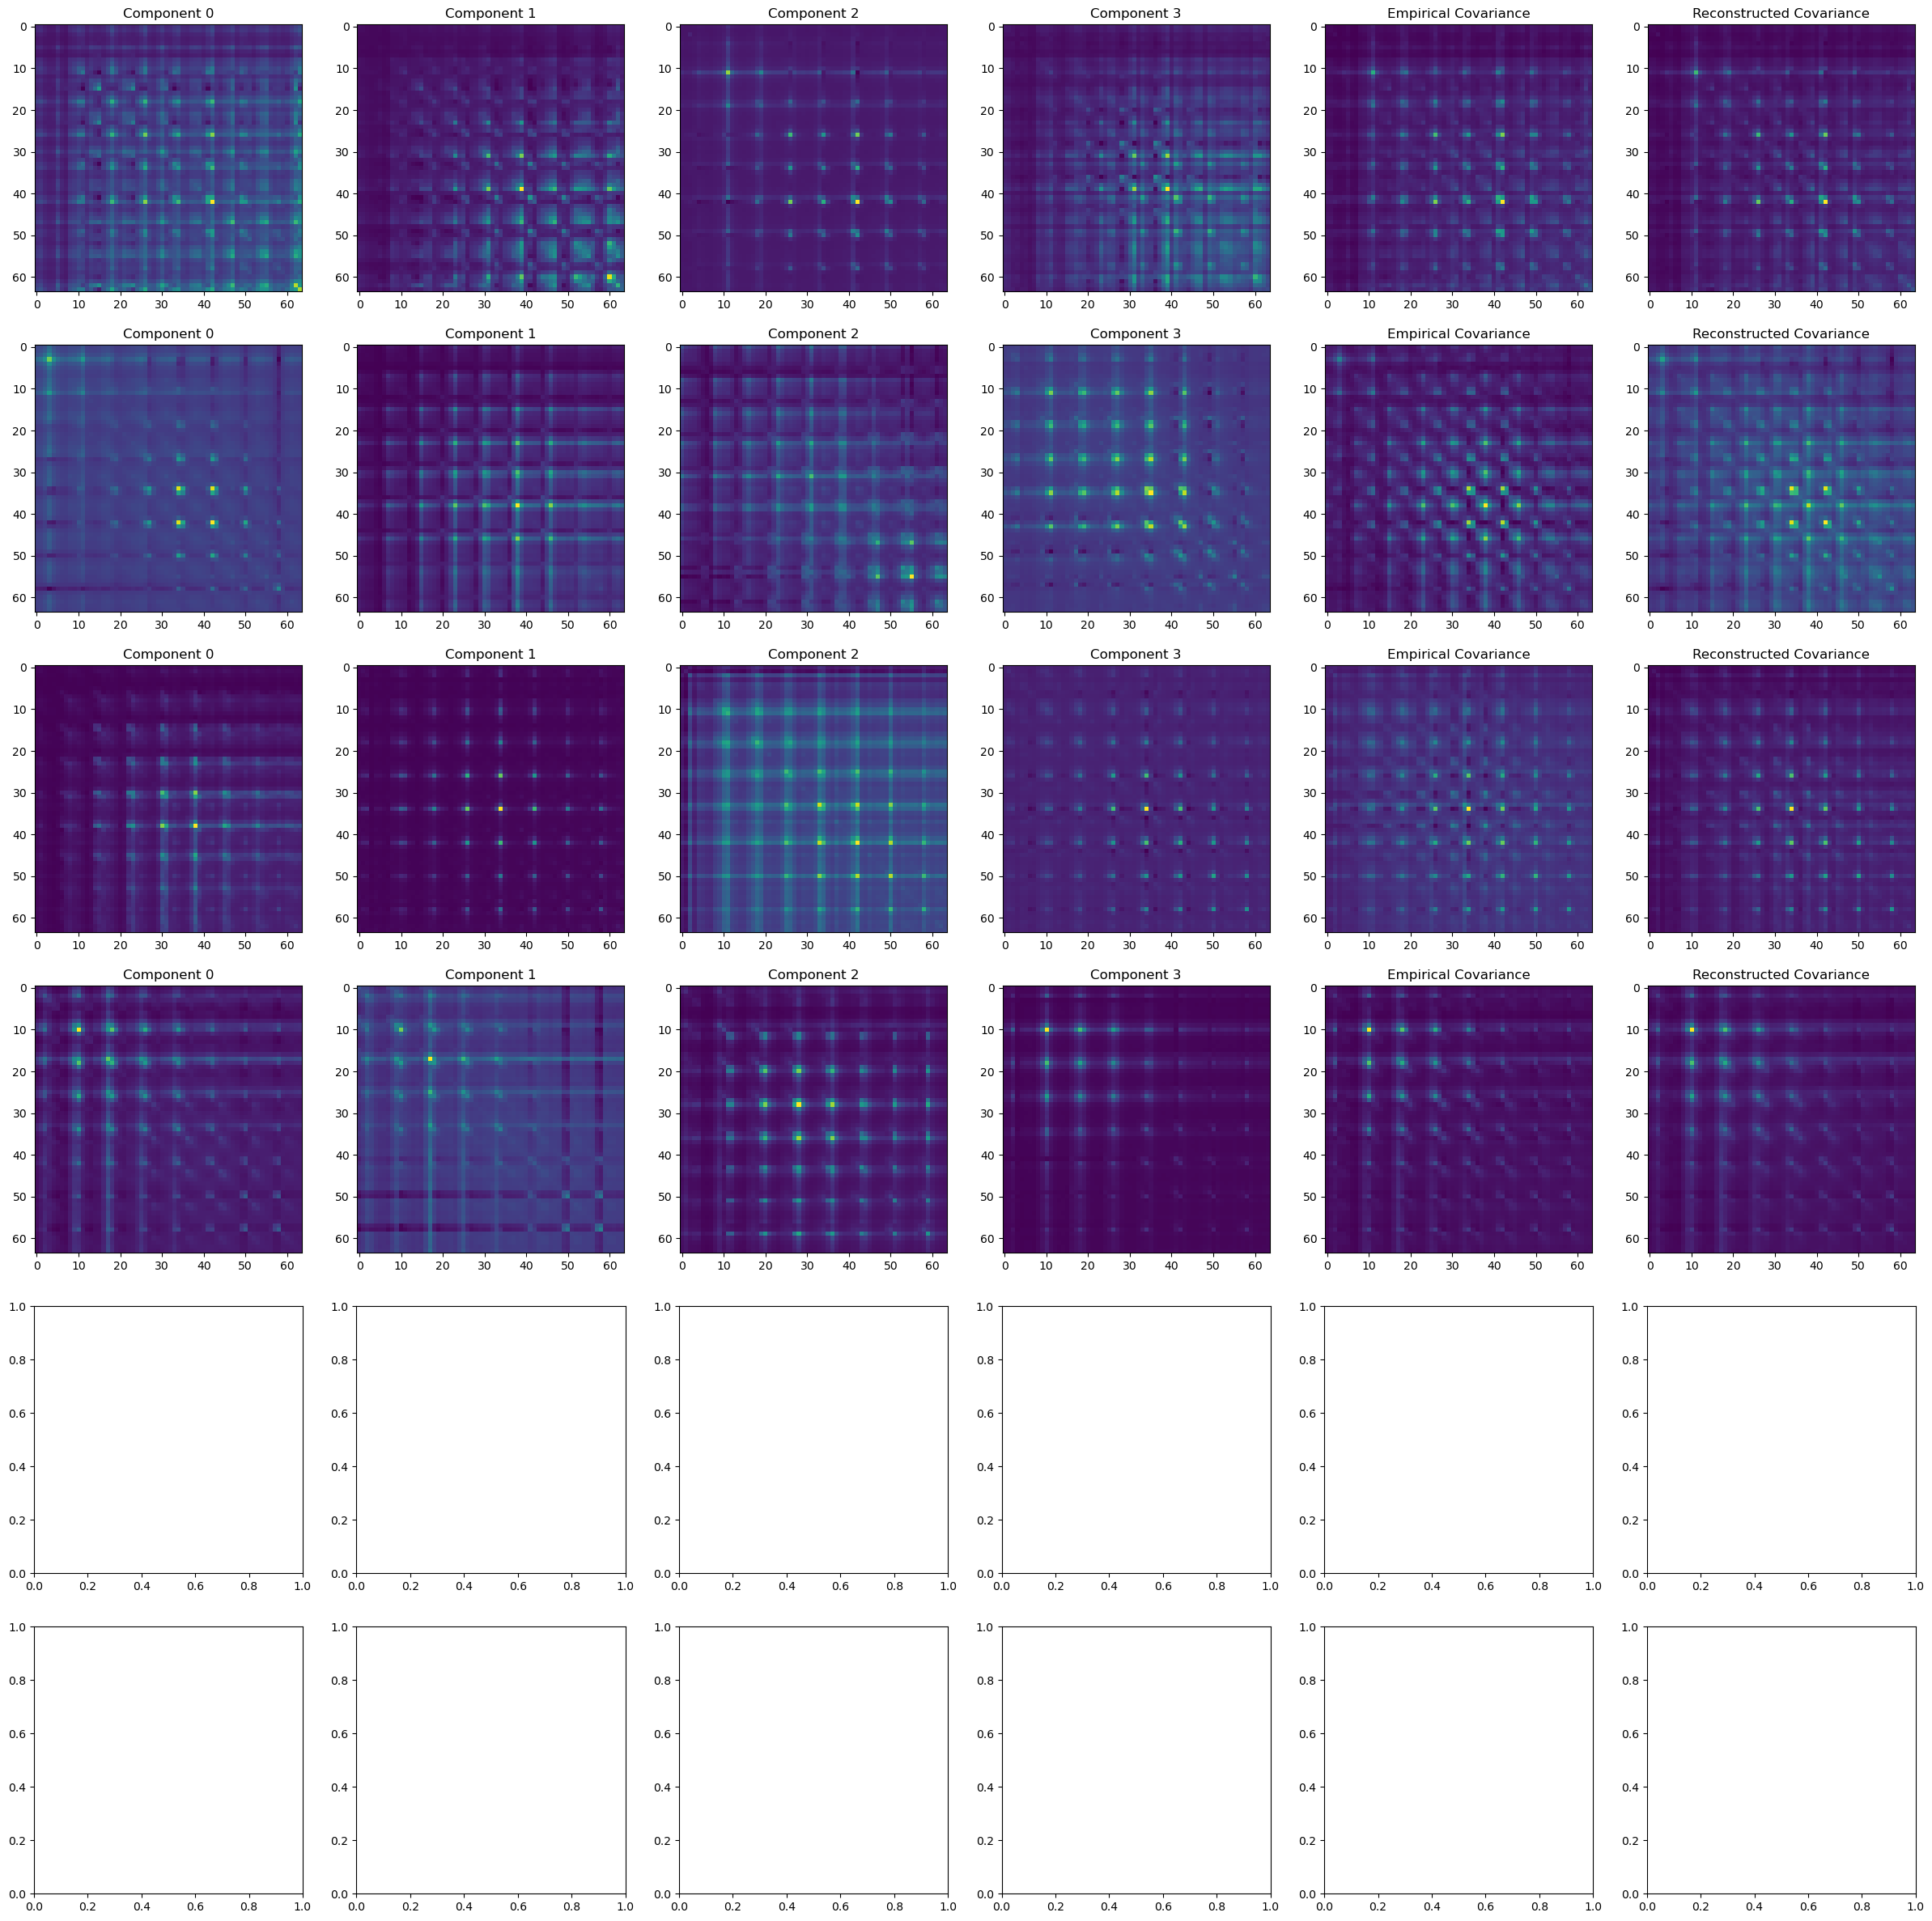

In [10]:
fig, axes = plt.subplots(6,6,figsize=(30,30))
for yaxi, si in enumerate(range(4)):
    model = subject_prior_models[si]
    cov_sum = np.zeros(shape=(64,64))
    for covi, (ax, cov) in enumerate(zip(axes[yaxi,:4].ravel(),model.covariances_)):
        ax.imshow(cov)
        ax.set_title(f"Component {covi}")
        cov_sum += model.weights_[covi]*cov
    data1 = subject_calibration_stacks[si].transpose((0,1,3,2)).reshape(-1,64)
    # data2 = subject_movement_stacks[si].transpose((0,1,3,2)).reshape(-1,64)
    # data = np.concatenate([data1,data2],axis=0)
    data = analysis.remove_nan_rows(data1)
    axes[yaxi,4].imshow(np.cov(data.T))
    axes[yaxi,4].set_title("Empirical Covariance")
    axes[yaxi,5].imshow(cov_sum)
    axes[yaxi,5].set_title("Reconstructed Covariance")

/Users/spencer/phd/phd/analysis/notebooks/../analysis/plot.py:72: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(


(-2.0, 2.0)

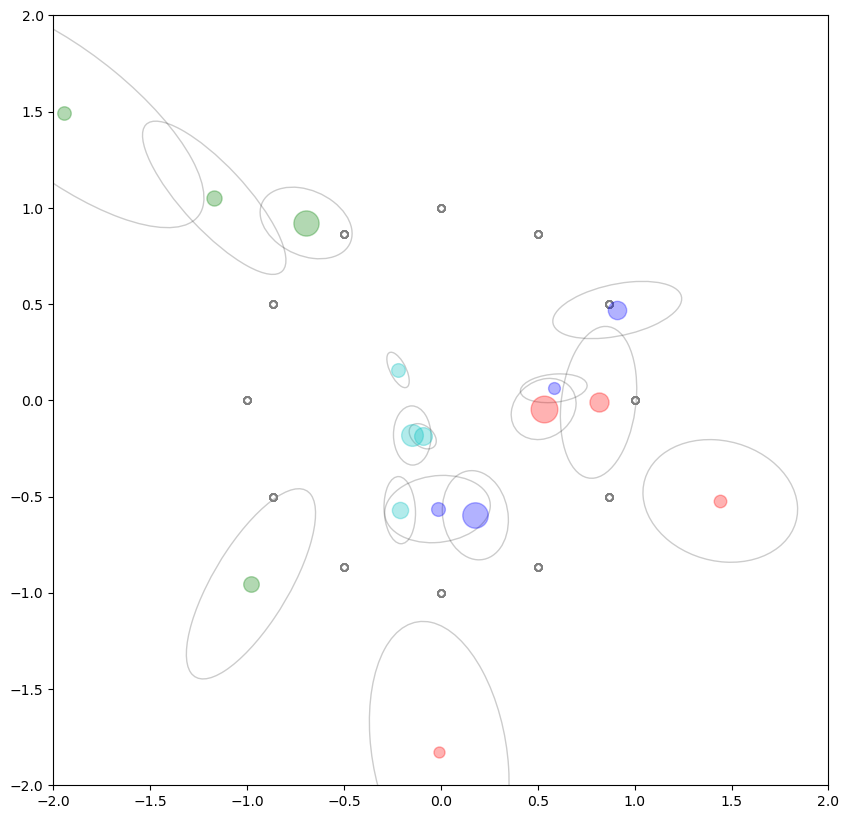

In [14]:
fig, model_ax = plt.subplots(1,1,figsize=(10,10))
c = ["r","b","g","c","m"]
for i, model in enumerate(subject_prior_models):
    for mean, covariance, weight in zip(model.means_,model.covariances_,model.weights_):
        decoder = subjects[i].decoder[-2:,:]
        tm = transform_mean(decoder, mean)
        tc = transform_covariance(decoder, covariance)
        model_ax.plot(tm[0],tm[1],c[i]+'o',zorder=100,markersize=weight*50,alpha=0.3)
        analysis_plot.plot_targets(model_ax, style="o", markersize=5, target=None)
        confidence_ellipse(tm,tc,model_ax,n_std=0.5,alpha=0.2)
model_ax.set_ylim([-2,2])
model_ax.set_xlim([-2,2])

## fit trial models

In [8]:
'''
weight_concentration_prior
    The higher concentration puts more mass in the center and 
    will lead to more components being active, while a lower 
    concentration parameter will lead to more mass at the edge 
    of the mixture weights simplex.
'''
# https://stats.stackexchange.com/questions/210103/choosing-prior-parameters-for-variational-mixture-of-gaussians
# https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture 
subject_models = []
for subject_idx in range(len(subjects)):
    model = BayesianGaussianMixture(n_components=4,
                                    weight_concentration_prior_type='dirichlet_process',
                                    weight_concentration_prior=1.e-8,
                                    init_params="k-means++",
                                    max_iter=200,
                                    n_init=3,
                                    warm_start=True,
                                    # verbose=True,
                                    random_state=0,
                                    # degrees_of_freedom_prior=64
                                    )
    block_stacks = subject_emg_stacks[subject_idx]
    models = []
    # 9 groups of 5 blocks each
    for block_idx in range(0,45,9):
        print(f"Fitting blocks {block_idx} to {block_idx+9}")
        signal = analysis.remove_nan_rows(block_stacks[block_idx:block_idx+9].reshape(-1,64))
        model.fit(signal)
        models.append(model)
        model = clone(model)
    subject_models.append(models)

Fitting blocks 0 to 9
Fitting blocks 9 to 18
Fitting blocks 18 to 27
Fitting blocks 27 to 36
Fitting blocks 36 to 45
Fitting blocks 0 to 9
Fitting blocks 9 to 18
Fitting blocks 18 to 27
Fitting blocks 27 to 36
Fitting blocks 36 to 45
Fitting blocks 0 to 9
Fitting blocks 9 to 18
Fitting blocks 18 to 27
Fitting blocks 27 to 36
Fitting blocks 36 to 45
Fitting blocks 0 to 9
Fitting blocks 9 to 18
Fitting blocks 18 to 27
Fitting blocks 27 to 36
Fitting blocks 36 to 45
Fitting blocks 0 to 9
Fitting blocks 9 to 18
Fitting blocks 18 to 27
Fitting blocks 27 to 36
Fitting blocks 36 to 45
Fitting blocks 0 to 9
Fitting blocks 9 to 18
Fitting blocks 18 to 27
Fitting blocks 27 to 36
Fitting blocks 36 to 45
Fitting blocks 0 to 9
Fitting blocks 9 to 18
Fitting blocks 18 to 27
Fitting blocks 27 to 36
Fitting blocks 36 to 45
Fitting blocks 0 to 9
Fitting blocks 9 to 18
Fitting blocks 18 to 27
Fitting blocks 27 to 36
Fitting blocks 36 to 45
Fitting blocks 0 to 9
Fitting blocks 9 to 18
Fitting blocks 18 t

In [16]:
len(subject_models)

46

In [17]:
# with open('subject_models.pkl', 'wb') as handle:
#     pickle.dump(subject_models, handle)


In [20]:
with open('subject_models.pkl', 'rb') as handle:
    test_models = pickle.load(handle)
print(test_models[0][1])

BayesianGaussianMixture(init_params='k-means++', max_iter=200, n_components=4,
                        n_init=3, random_state=0, warm_start=True,
                        weight_concentration_prior=1e-08)


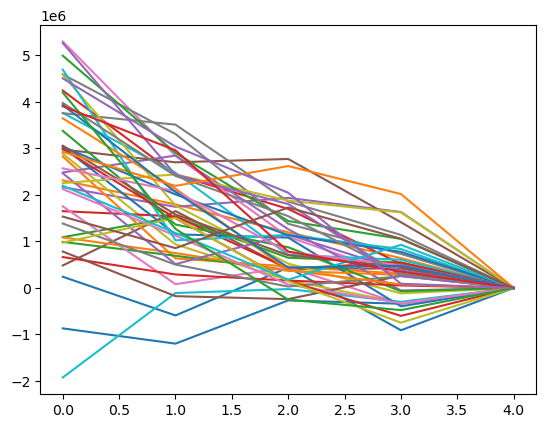

In [23]:
for models in subject_models:
    end_bound = models[-1].lower_bound_
    plt.plot([model.lower_bound_ - end_bound for model in models])

Text(0, 0.5, 'Weight')

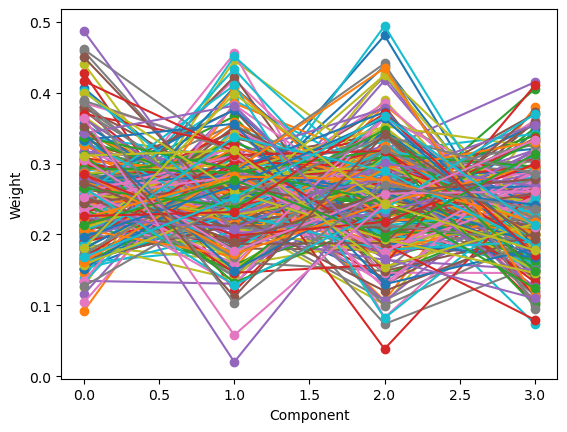

In [25]:
fig, weight_ax = plt.subplots(1,1)
for models in subject_models:
    for mi, model in enumerate(models):
        weight_ax.plot(model.weights_,"-o")
plt.xlabel("Component")
plt.ylabel("Weight")

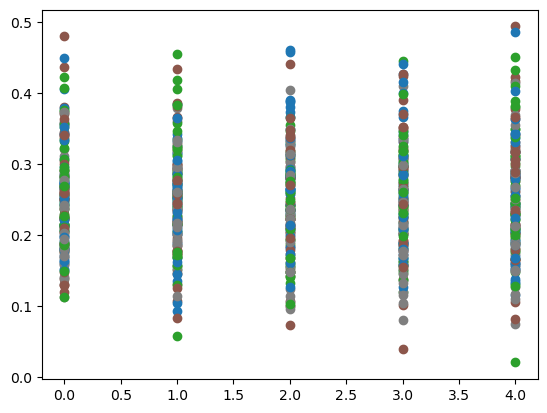

In [28]:
# for each weight (index), plot across models 
fig, component_ax = plt.subplots(1,1)
for models in subject_models:
    for i in range(4):
        for mi, model in enumerate(models):
            component_ax.plot(mi, model.weights_[i],"o",color=colormaps["tab10"](i/4))

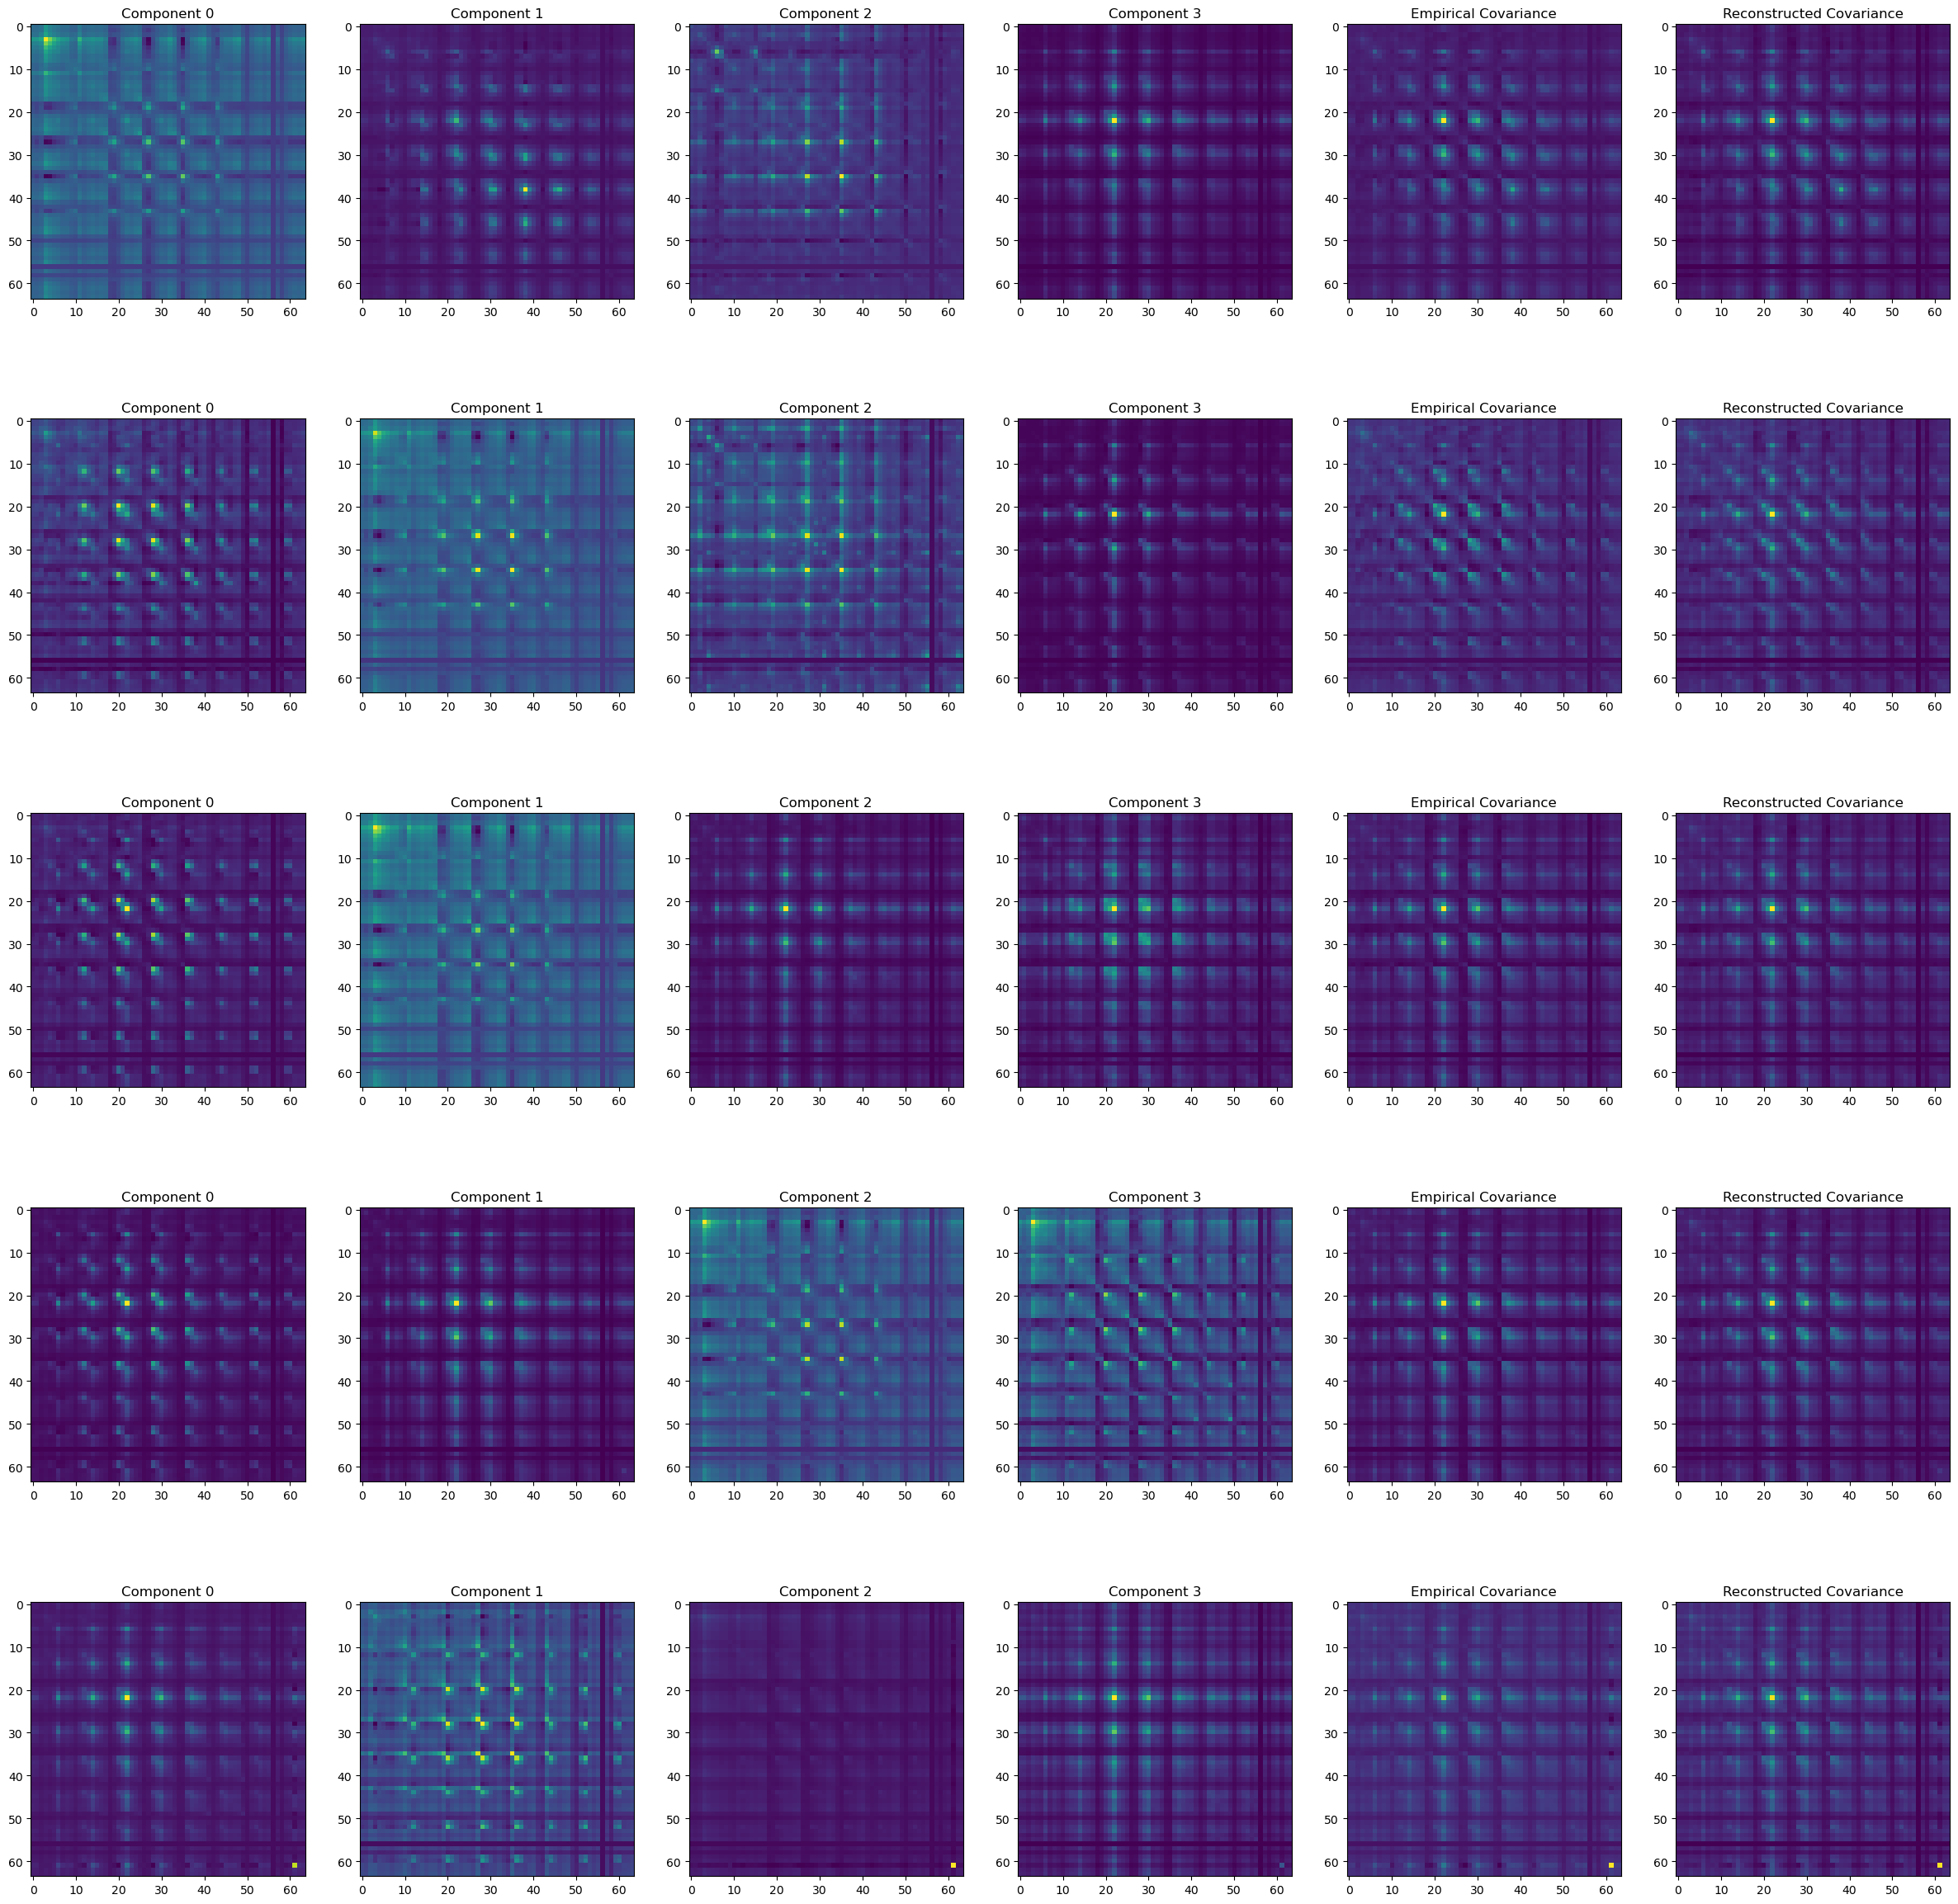

In [36]:
fig, axes = plt.subplots(len(models),6,figsize=(30,30))
subject_idx = 5
block_stacks = subject_emg_stacks[subject_idx]
models = subject_models[subject_idx]
for mi, model in enumerate(models):
    cov_sum = np.zeros(shape=(64,64))
    for covi, (ax, cov) in enumerate(zip(axes[mi,:4].ravel(),model.covariances_)):
        ax.imshow(cov)
        ax.set_title(f"Component {covi}")
        cov_sum += model.weights_[covi]*cov
    signal = analysis.remove_nan_rows(block_stacks[mi*9:(mi*9)+9].reshape(-1,64))
    axes[mi,4].imshow(np.cov(signal.T))
    axes[mi,4].set_title("Empirical Covariance")
    axes[mi,5].imshow(cov_sum)
    axes[mi,5].set_title("Reconstructed Covariance")

In [37]:
lower_tris =  np.array([cov[np.tril_indices(64)] for cov in model.covariances_])
np.concatenate([lower_tris,lower_tris],axis=1).shape

(4, 4160)

In [39]:
# links from model i to i+1
# for pair in pairs:
    # for component in pair:
        # component[0] --> component[1]
        # model i component idx --> model i+1 component idx

# TODO:
# - get the means_ and weights_ and covariances_ lists for each model in an order that's consistent
# - 

# model_mean_pairs

In [307]:
# insensitive to magnitude, "directional"
def cosine_distance(A,B):
    return 1 - (np.trace(np.dot(A,B)) / (np.linalg.norm(A,ord='fro') * np.linalg.norm(B,ord='fro')))

# sensitive to magnitudes
def frobenius_difference(A,B):
    return np.linalg.norm(A-B,ord='fro')

A = np.eye(10)
B = np.fliplr(np.eye(10))
cosine_distance(A,B), frobenius_difference(A,B)

(1.0, 4.47213595499958)

In [340]:
models = subject_models[8]

/Users/spencer/phd/phd/analysis/notebooks/../analysis/plot.py:72: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(
/Users/spencer/phd/phd/analysis/notebooks/../analysis/plot.py:72: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


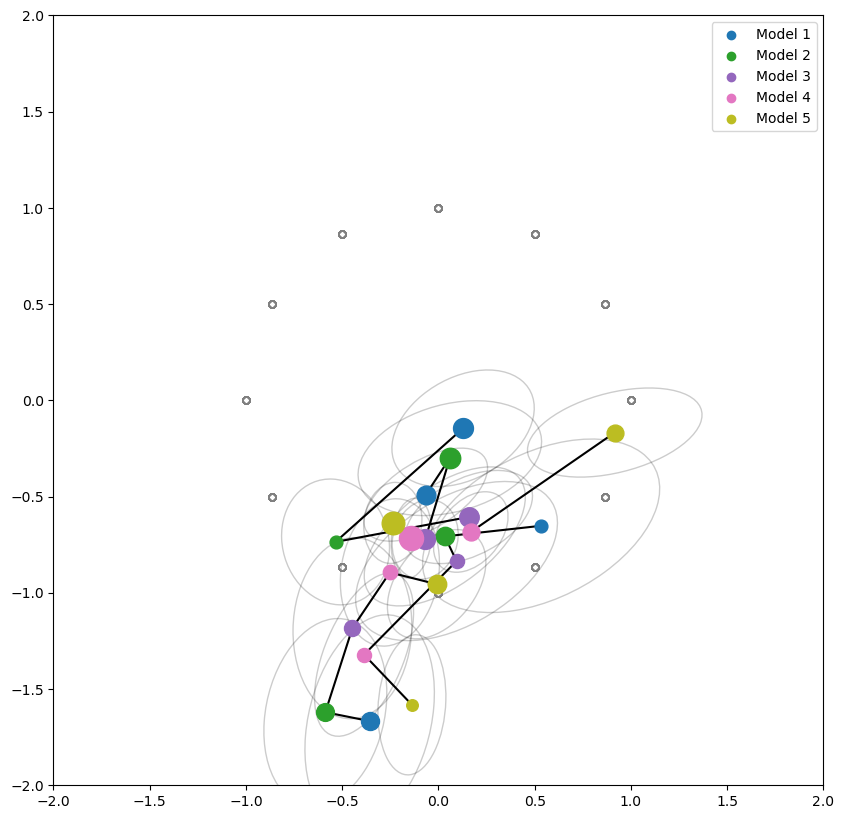

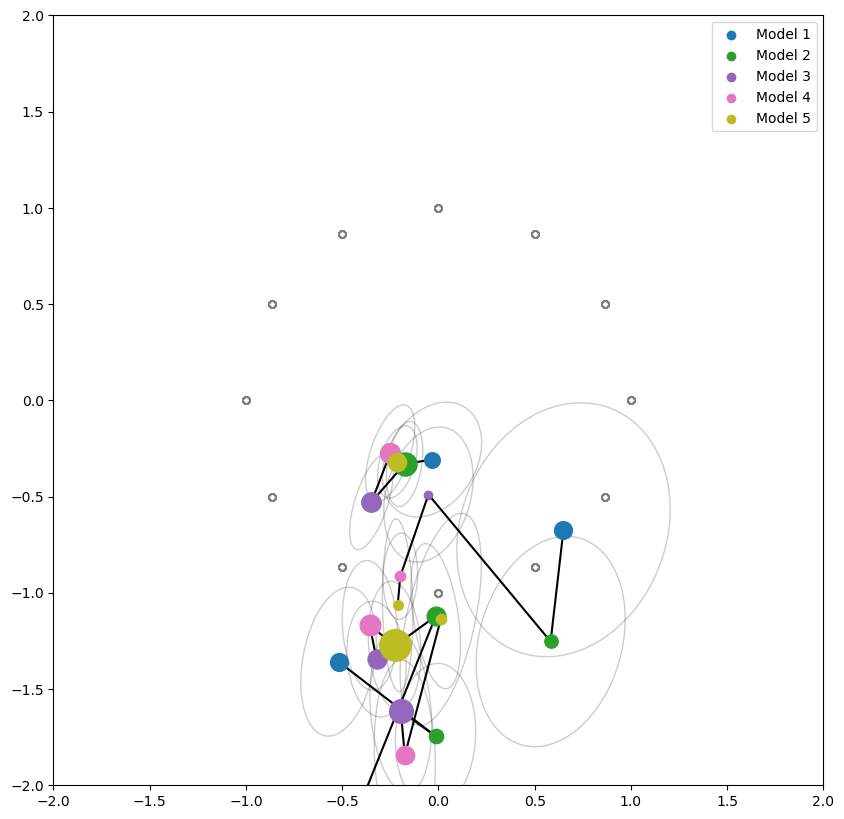

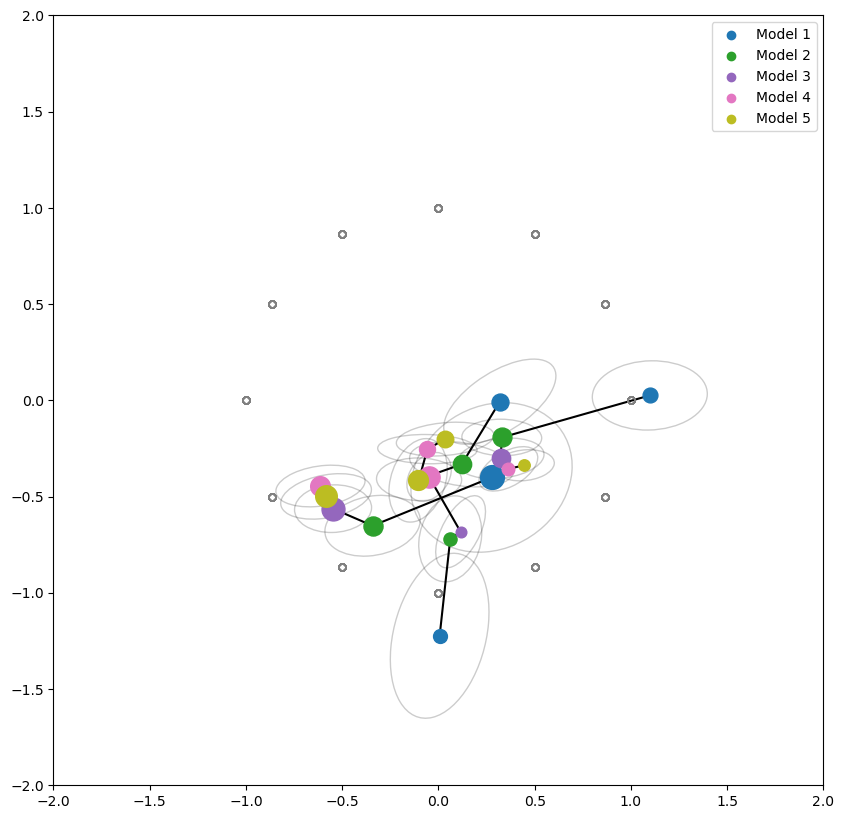

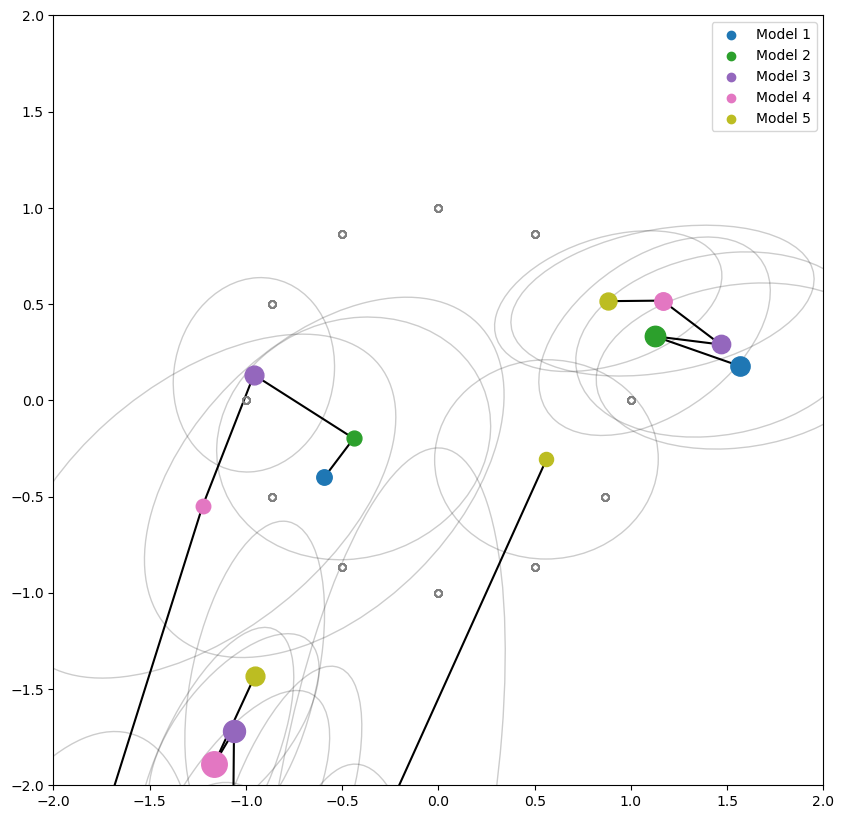

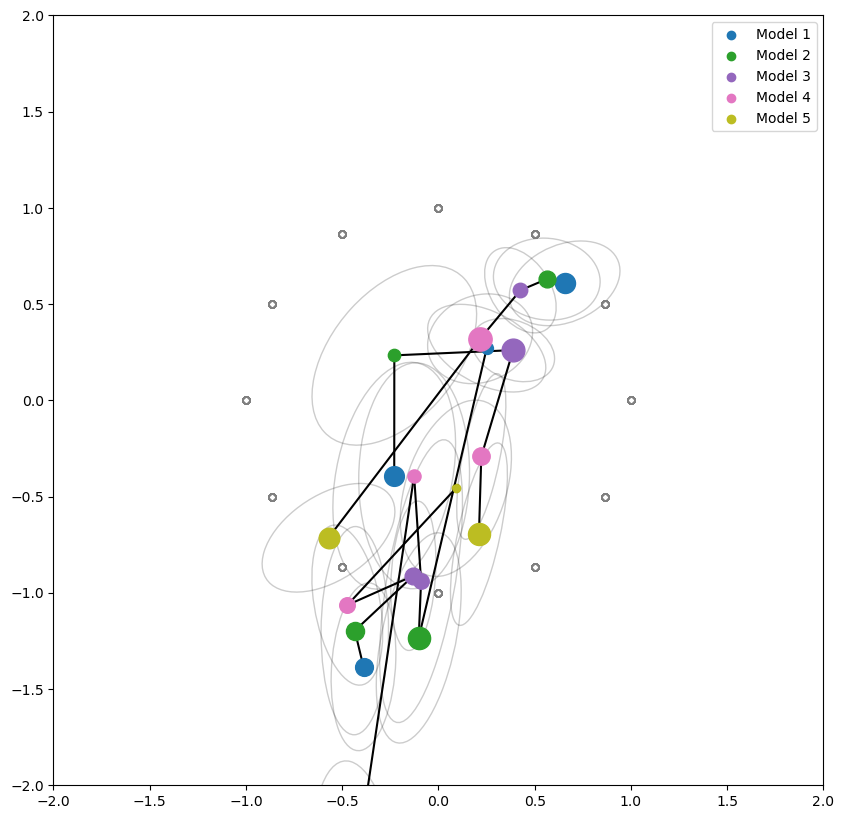

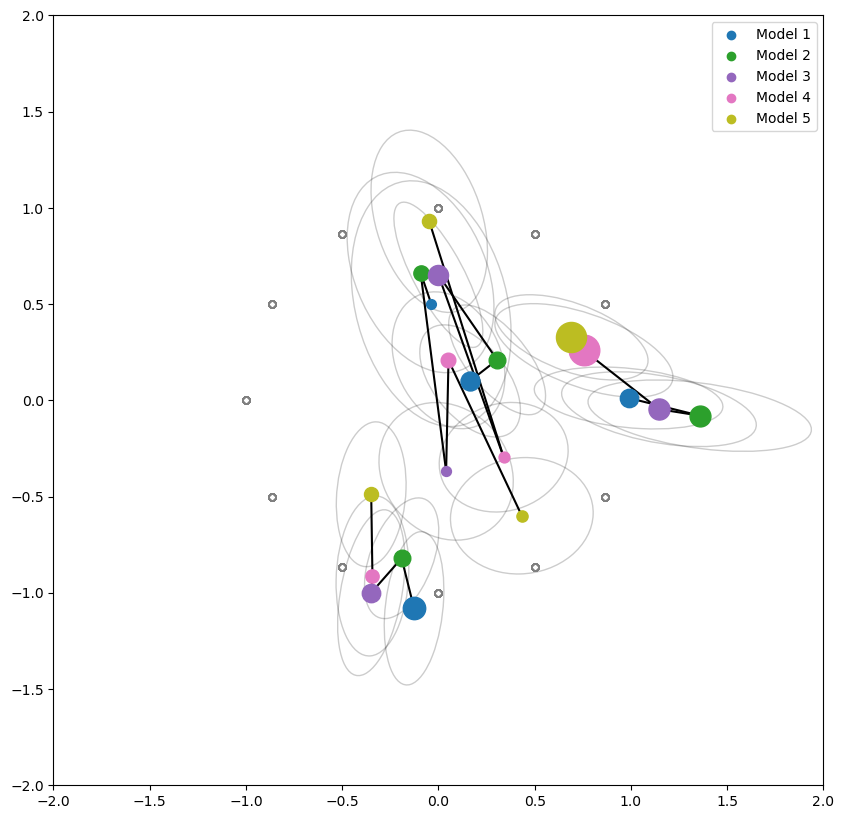

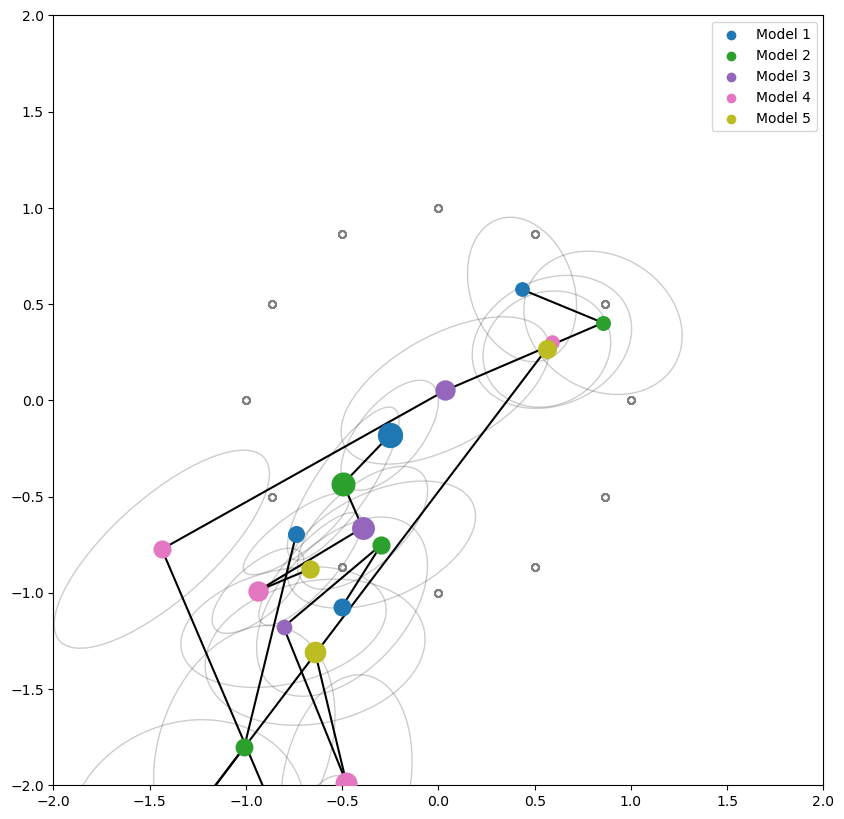

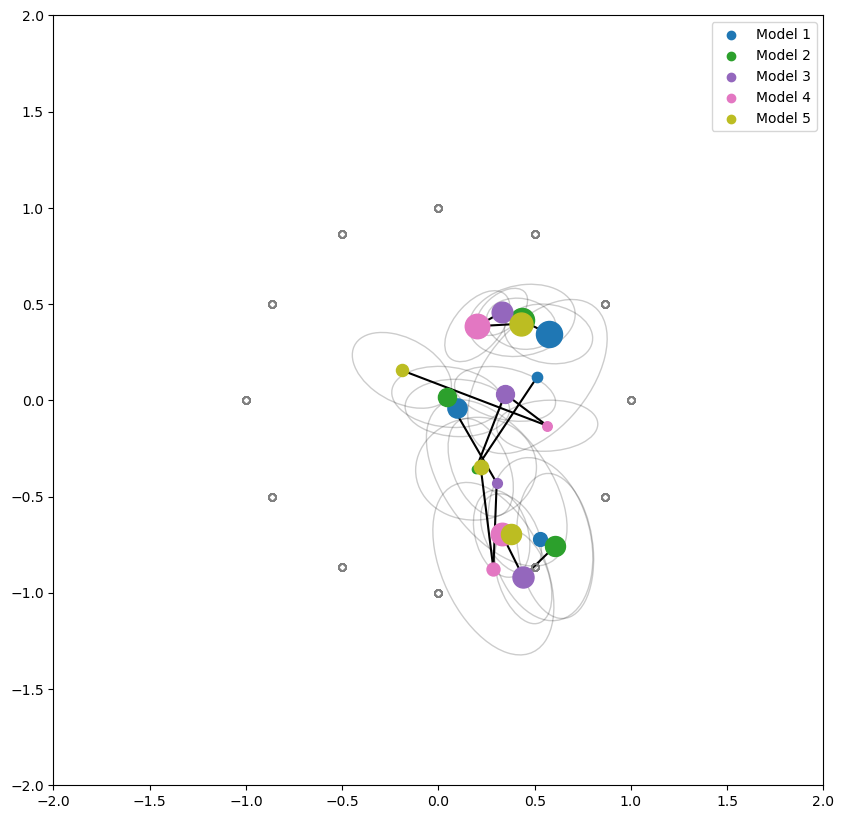

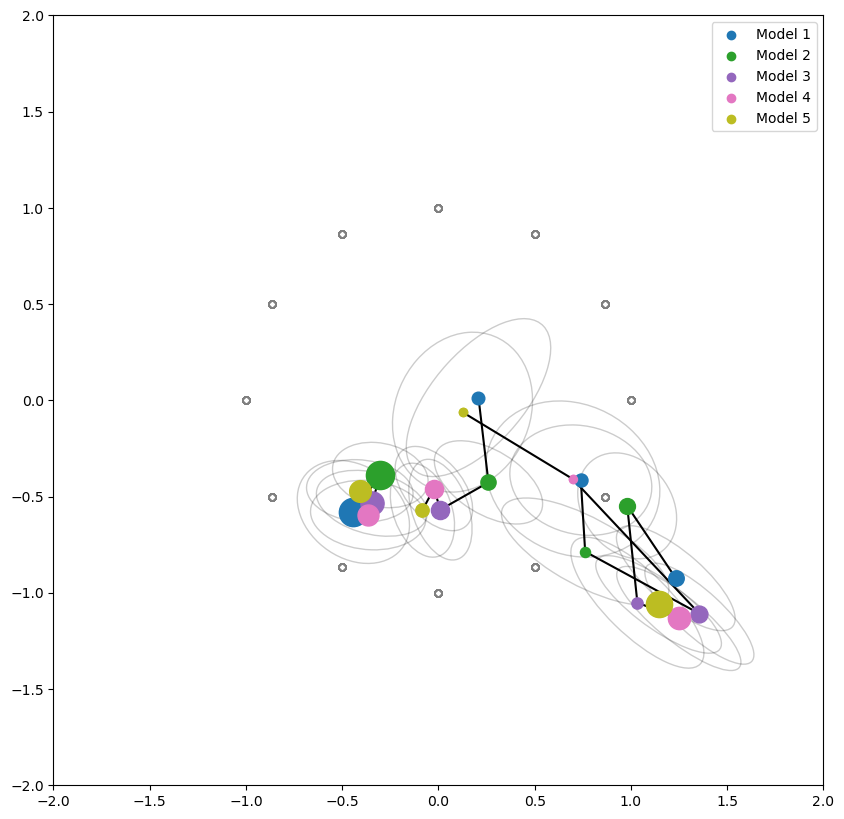

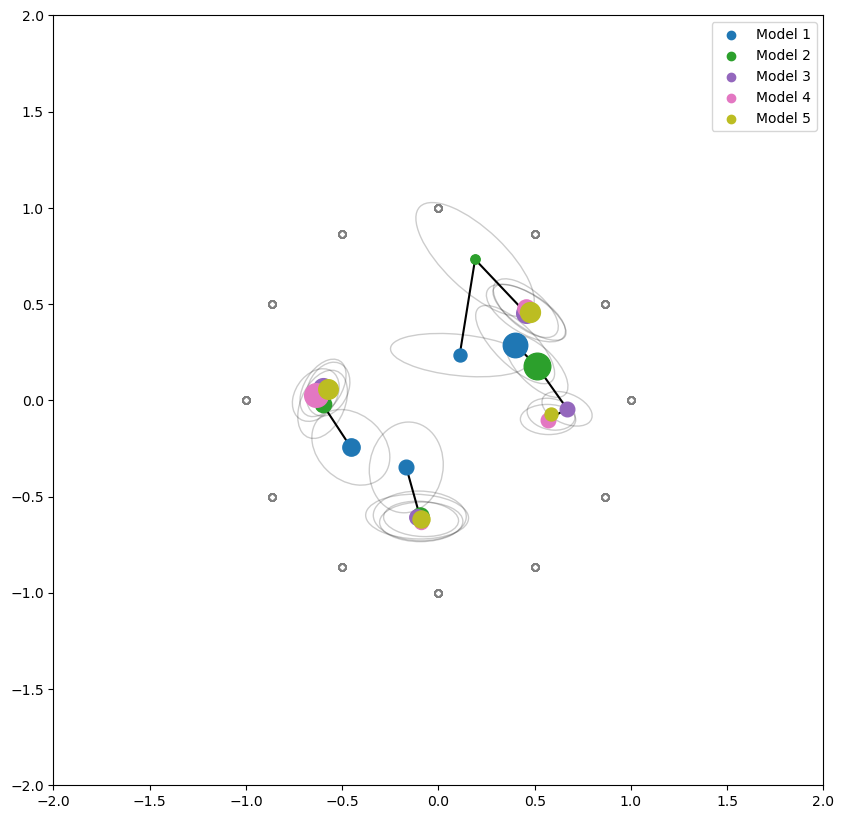

In [351]:
for i in range(20,30):
    models = subject_models[i]
    fig, model_ax = plt.subplots(1,1,figsize=(10,10))
    model_ax.set_aspect("equal")

    # matching means in 2D not 64D
    transformed_means = []
    for model in models:
        transformed_means.append(decoder @ model.means_.T)
    transformed_means = np.array(transformed_means)
    # models x xy x dims

    # def augment_mean(model):
    #     lower_tris =  np.array([[cov[np.tril_indices(64)] for cov in model.covariances_] for model in models])
    #     np.concatenate([lower_tris,lower_tris],axis=2).shape

    # try distances in 64D space
    # weight the means up to prioritize them
    mean_weight = 1.0
    weight_weight = 0.0
    cov_weight = 0.0
    model_mean_pairs = []
    for model_1, model_2 in zip(models[:-1],models[1:]):
        lower_tris1 =  np.array([cov[np.tril_indices(64)] for cov in model_1.covariances_])
        lower_tris2 =  np.array([cov[np.tril_indices(64)] for cov in model_2.covariances_])
        model_1_vec = np.concatenate([model_1.means_*mean_weight,lower_tris*cov_weight,model_1.weights_.reshape(-1,1)*weight_weight],axis=1)
        model_2_vec = np.concatenate([model_2.means_*mean_weight,lower_tris*cov_weight,model_2.weights_.reshape(-1,1)*weight_weight],axis=1)
        # print(model_1_vec.shape, model_2_vec.shape)
        model_mean_pairs.append(closest_pairs(model_1_vec,model_2_vec))
    model_mean_pairs = np.array(model_mean_pairs)
    # model_pairs, components, model1_idx,model2_idx

    linestyles = ["solid","dotted","dashed","dashdot"]
    for model_idx, mean_pair in enumerate(model_mean_pairs):
        for i, component_pair in enumerate(mean_pair):
            x1 = transformed_means[model_idx,0,component_pair[0]]
            x2 = transformed_means[model_idx+1,0,component_pair[1]]
            y1 = transformed_means[model_idx,1,component_pair[0]]
            y2 = transformed_means[model_idx+1,1,component_pair[1]]
            h = model_ax.plot([x1,x2], [y1,y2],color="k")#,linestyle=linestyles[component_pair[0]])
        # h[0].set_label(f"Component {component_pair[0]}")

    for i, model_tms in enumerate(transformed_means):
        for component_mean in model_tms.T:
            h = model_ax.scatter(component_mean[0],component_mean[1],color=colormaps["tab10"](i/transformed_means.shape[0]))
        h.set_label(f"Model {i+1}")

    for i, model in enumerate(models):
        for mean, covariance, weight in zip(model.means_,model.covariances_,model.weights_):
            tm = transform_mean(decoder, mean)
            tc = transform_covariance(decoder, covariance)
            model_ax.plot(tm[0],tm[1],'o',zorder=100,color=colormaps["tab10"](i/len(models)),markersize=weight*50)
            analysis_plot.plot_targets(model_ax, style="ko", markersize=5, target=None)
            # plot_eigs(tm,tc,model_ax,color='k',alpha=0.1)
            # plot_gaussian(tm,tc,ax=model_ax)
            confidence_ellipse(tm,tc,model_ax,n_std=0.5,alpha=0.2)

    model_ax.set_ylim([-2,2])
    model_ax.set_xlim([-2,2])
    model_ax.legend()

ratio of (model1-model2 / model4-model5) -- how different are first and last jumps?

In [329]:
subject_diffs = []
for models in subject_models:
    model_diffs = []
    for model_idx, mean_pair in enumerate(model_mean_pairs):
        component_diffs = []
        for i, component_pair in enumerate(mean_pair):
            # model x --> model y
            component_diffs.append(frobenius_difference(models[model_idx].covariances_[component_pair[0]], models[model_idx+1].covariances_[component_pair[1]]))
        model_diffs.append(component_diffs)
    subject_diffs.append(model_diffs)

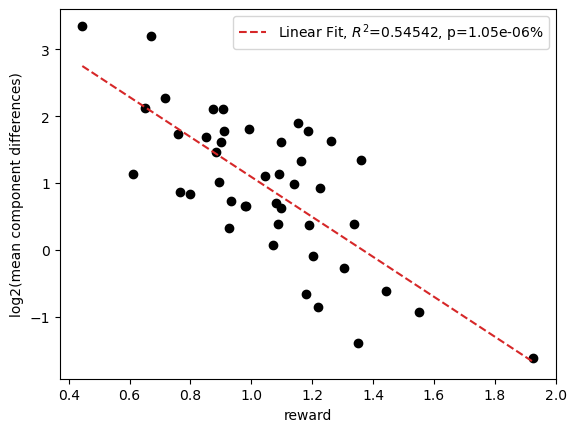

In [378]:
mean_diffs = []
diff_rewards = []
for i, model_diffs in enumerate(subject_diffs):
    if not i in [36,45]:
        diff_rewards.append(mean_rewards[i])
        mean_diffs.append(np.mean(model_diffs))
plt.figure()
# plt.gca().set_yscale('log', base=2)
plt.plot(diff_rewards,np.log2(mean_diffs),"ko")
r = linear_fit(diff_rewards,np.log2(mean_diffs))
x = np.linspace(np.min(diff_rewards),np.max(diff_rewards),100)
plt.gca().plot(x, (r.intercept + r.slope*x),"--", color="tab:red", label=f"Linear Fit, $R^2$={np.round(r.rvalue**2, 5)}, p={np.round(r.pvalue*100,9)}%")
plt.ylabel("log2(mean component differences)")
plt.xlabel("reward")
plt.legend()

/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/seaborn/_oldcore.py:111

(-2.0, 2.0)

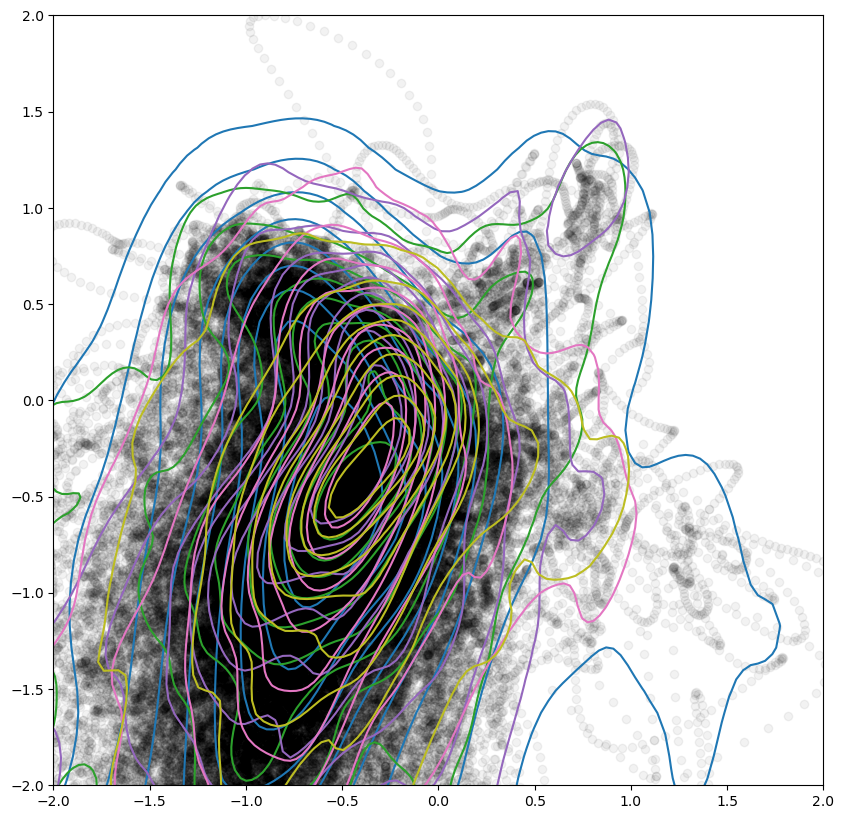

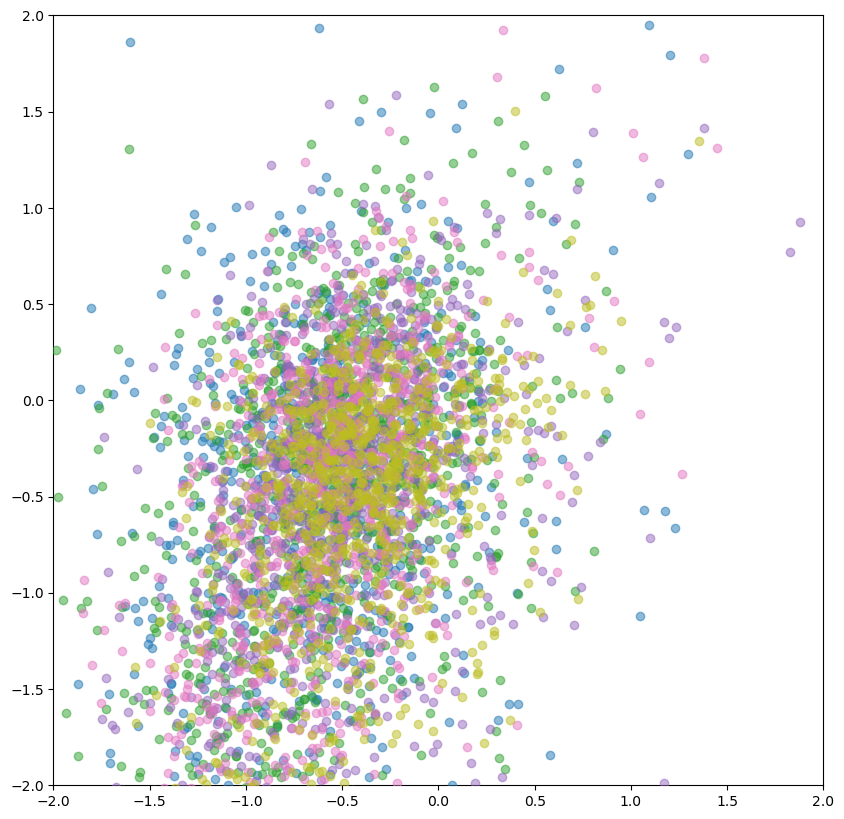

In [42]:
# model = models[0]
colors = ["tab:blue","tab:red","tab:green","tab:orange"]
fig, data_ax = plt.subplots(1,1,figsize=(10,10))
data_ax.set_aspect("equal")
fig, sample_ax = plt.subplots(1,1,figsize=(10,10))
sample_ax.set_aspect("equal")
for i, model in enumerate(models):
    traj = decoder @ analysis.remove_nan_rows(block_stacks[(i*9):(i*9)+9].reshape(-1,64)).T
    data_ax.plot(traj[0],traj[1],"ko",alpha=0.05,zorder=-10)
    sns.kdeplot(x=traj[0],y=traj[1],color=colormaps["tab10"](i/len(models)),alpha=1.0,zorder=-1,ax=data_ax)
    samples, components = model.sample(1000)
    ts = decoder @ samples.T
    sample_ax.plot(ts[0],ts[1],'o',zorder=100,color=colormaps["tab10"](i/len(models)),alpha=0.5)
data_ax.set_ylim([-2,2])
data_ax.set_xlim([-2,2])
sample_ax.set_ylim([-2,2])
sample_ax.set_xlim([-2,2])

## rank of the component covariance -- subspace confinement

Text(0, 0.5, 'Variance')

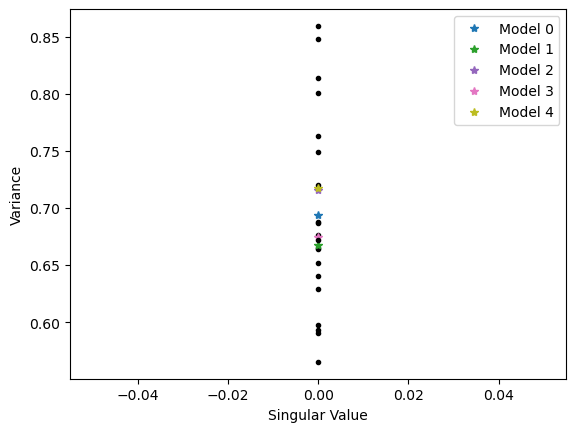

In [115]:
# subjects, model, component, singular vals
n_sing_vals = 1
s = np.zeros(shape=(46,5,4,n_sing_vals))
for si, models in enumerate(subject_models):
    for i, model in enumerate(models):
        # each model over time
        for k, cov in enumerate(model.covariances_):
            # svd of each of the 4 components
            U, S, V = np.linalg.svd(cov)
            s[si,i,k,:] = S[:n_sing_vals]/S.sum()

si = 5
# for each model
for i in range(5):
    # mean over components
    for k in range(4):
        plt.plot(s[si,i,k],"k.")
    plt.plot(s[si,i].mean(axis=0), "*", c=colormaps["tab10"](i/5), label=f"Model {i}") #, marker=markers[i])
plt.legend()
plt.xlabel("Singular Value")
plt.ylabel("Variance")

We expect more confinement will make it more difficult for subjects to reach targets.

We measure confinement by looking at the rank of individual covariance matrices.

Text(0, 0.5, 'Variance of Model Covariance First Singular Value')

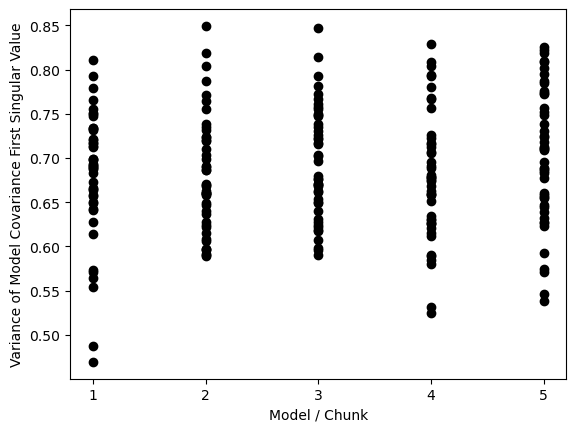

In [242]:
for si in range(46):
    plt.scatter(x=range(5), y=s[si,:,:,0].mean(axis=-1),color="k")
    # plt.errorbar(x=range(5),y=s[si,:,:,0].mean(axis=1),linestyle="none",marker="o",yerr=s[si,:,:,0].std(axis=1)/(np.sqrt(s.shape[2])),capsize=4,label="Mean $\pm$ Std Err")
plt.xticks(range(5),labels=range(1,6))
plt.xlabel("Model / Chunk")
plt.ylabel("Variance of Model Covariance First Singular Value")
# plt.legend()

In [152]:
def linear_fit(x_data, y_data):
    result = sp.stats.linregress(x_data, y_data)
    return result

def plot_linear_fit(x, result, ax):
    ax.plot(x, result.intercept + result.slope*x,"--", color="tab:red", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}, p={np.round(result.pvalue*100,3)}%")

In [153]:
top_weight_idxs = np.zeros(46,dtype=np.int16)
top_weights = np.zeros(46)
for i, models in enumerate(subject_models):
    # first model
    m = models[0]
    top_weight_idxs[i] = np.argmax(m.weights_)
    top_weights[i] = np.sort(m.weights_,)[::-1][:2].sum()

In [154]:
s[i,0,:,0].shape

(4,)

## max singular value component vs. hits,reward

(0.0, 1.0)

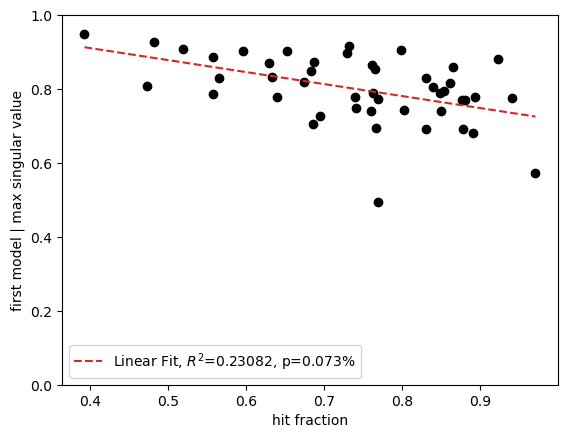

In [251]:
# first model, components, first singular value
k = 0
plt.figure()
plt.plot(hit_fractions, [s[i,k,:,0].max() for i in range(46)],"ko")
r = linear_fit(hit_fractions,[s[i,k,:,0].max() for i in range(46)])
x = np.linspace(min(hit_fractions),max(hit_fractions),100,endpoint=True)
plot_linear_fit(x,r,plt.gca())
plt.legend()
plt.xlabel("hit fraction")
plt.ylabel("first model | max singular value")
plt.ylim([0,1])
# plt.xlim([0,1])

(0.4, 1.5)

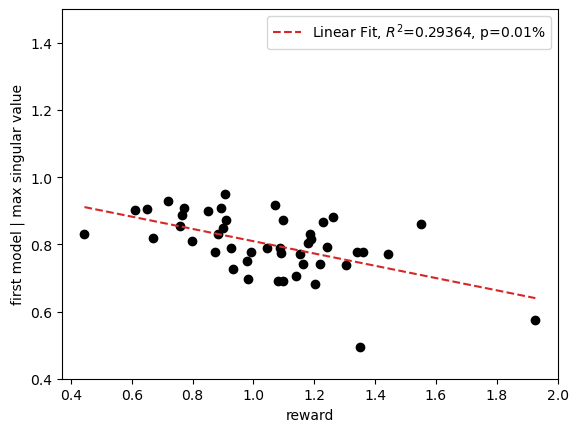

In [257]:
# first model, components, first singular value
k = 0
plt.figure()
plt.plot(mean_rewards, [s[i,k,:,0].max() for i in range(46)],"ko")
r = linear_fit(mean_rewards,[s[i,k,:,0].max() for i in range(46)])
x = np.linspace(mean_rewards.min(),mean_rewards.max(),100,endpoint=True)
plot_linear_fit(x,r,plt.gca())
plt.legend()
plt.xlabel("reward")
plt.ylabel("first model | max singular value")
# plt.xlim([0.2,2.2])
plt.ylim([0.4,1.5])

### ^^ this points to subspace confinement being linked to performance -- higher performers tend to have more "spread" activity, or are less "subspace confined" -- this makes sense!

# what changes over the course of learning? 

Can we develop metrics across learning that show WHAT people are learning?

Our hint is that variance decreases over time-- we want to capture this succinctly, e.g. Sum(Tr(Cov))?

We know that we get this X-pattern because of subspace confinement, so we might expect subjects to unconfine themselves over the course of learning-- the top singular value would tend to decrease in variance over learning.

This needs to be relative to the subject's total variance? 

The correlation between performance and subspace confinment goes away over time-- subjects become less confined?

The activities become more self-similar over time-- the correlation/distance between subsequent models increases? the difference between subsequent models decreases? 

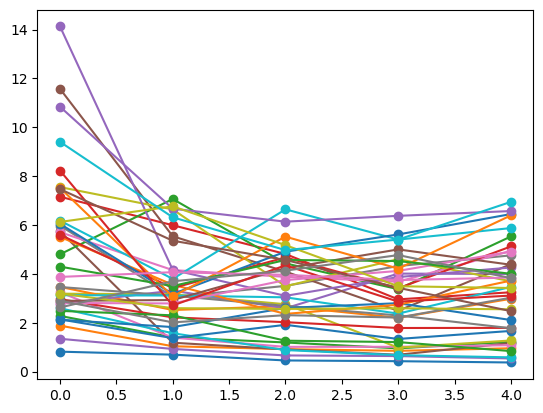

In [238]:
mean_variances = [[np.mean([np.trace(c).sum() for c in model.covariances_]) for model in models] for models in subject_models]
top_reward_idxs = np.argsort(mean_rewards)[::-1][:46].tolist()
ignore_idxs = [8,38,42,43,44,45,46]
for ii, i in enumerate(top_reward_idxs):
    if not (ii in ignore_idxs):
        plt.plot(mean_variances[i], "-o")

(-2.0, 2.0)

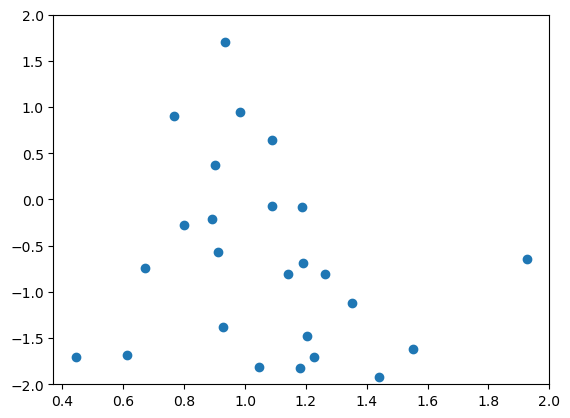

In [240]:
# does the variance decrease over models?
diffs = []
for i in top_reward_idxs:
    diffs.append(np.sum ([np.trace(c).sum() for c in subject_models[i][-1].covariances_]) - np.sum   ([np.trace(c).sum() for c in subject_models[i][0].covariances_]))
plt.plot([mean_rewards[i] for i in top_reward_idxs], diffs,"o")
plt.ylim([-2,2])

Does the subspace confinement change?

## look at GMM covariance task/null space projections

In [518]:
# test subspace projection
task, null = analysis.compute_subspaces(decoder)
print(task.shape, null.shape)

(2, 64) (62, 64)


In [519]:
def stacked_subspace_projection(C,d):
    t, n = analysis.compute_subspaces(d)
    s = np.row_stack([t,n])
    return analysis.subspace_projection(C, s)

In [520]:
# project each component of each model
# model, component, projection vec
projections = np.zeros(shape=(5,4,64))
markers = [".","*","o","v","s"]
for i, model in enumerate(models):
    for k, cov in enumerate(model.covariances_):
        projections[i,k,:] = stacked_subspace_projection(cov,decoder)

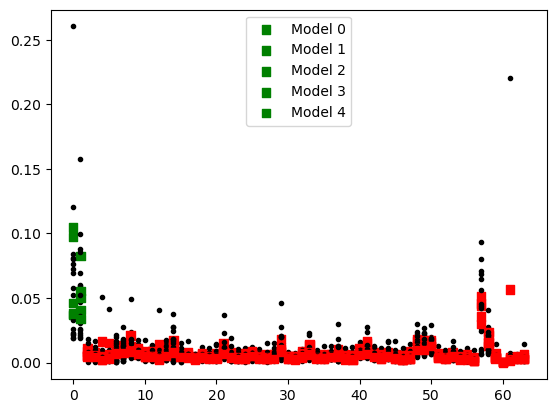

In [ ]:
# plot the projections and color the mean for each model
for model_idx in range(5):
    for cpt_idx in range(4):
        p = projections[model_idx, cpt_idx]
        plt.scatter(np.arange(p.shape[0]), p, color="k", marker=".")
    plt.scatter(np.arange(p.shape[0]), np.mean(projections, axis=1)[model_idx], marker=markers[i], c=["g","g"] + ["r" for _ in range(62)], label=f"Model {model_idx}")
plt.legend()

In [522]:
task, null = analysis.compute_subspaces(decoder)
mean_projections = np.zeros(shape=(5,4,3))
markers = [".","*","o","v","s"]
print(task.shape, null.shape)
for i, model in enumerate(models):
    for k, cov in enumerate(model.covariances_):
        mean_projections[i,k,0] = analysis.mean_quadratic_form(cov,task)[0] # *models[i].weights_[k]
        mean_projections[i,k,1] = analysis.mean_quadratic_form(cov,null)[0] # *models[i].weights_[k]
        mean_projections[i,k,2] = mean_projections[i,k,0] / mean_projections[i,k,1]

(2, 64) (62, 64)


Text(0, 0.5, 'Task/Null Ratio')

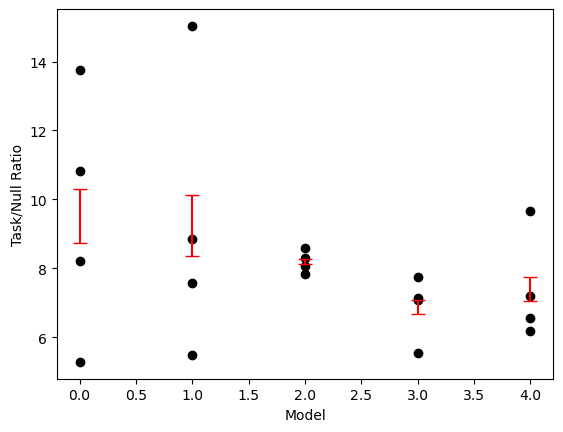

In [549]:
for i in range(5):
    for k in range(4):
        plt.plot(i, mean_projections[i,k,2],'ko')
plt.errorbar(x=list(range(5)),y=np.mean(mean_projections[:,:,2],axis=1),yerr=np.std(mean_projections[:,:,2],axis=1)/4,color='r',capsize=5,linestyle="none")
plt.xlabel("Model")
plt.ylabel("Task/Null Ratio")

#### To look at task/null variance, we need to focus on the ERROR signal-- this is the NOISE apart from doing the task itself. 

#### BUT we can't do this! Because we don't have a trajectory --> EMG model... we can:
- try to interpret this in light of the task data
- fit a model from trajectory to EMG, then subtract that off from the EMG? E.g. A*t = e', err = |e - e'|**2 ?

If we take the HIT emg ends, stack those, then fit a model from that point to that EMG activity, then we could subtract that EMG activity off of the other EMG.

Now we have error_emg for every trial. Then we can try to project.

What we have now is still interesting, it's looking at on-manifold activity vs. off. But this is kind of "manifold activity" (are we moving on or off manifold), less specific than "manifold error" (are we making mistakes / irrelevant activity on or off manifold).